# Covid Cases and Deaths Dataset
_____

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import missingno as msno
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

import warnings # necessary b/c pandas & statsmodels datetime issue
warnings.simplefilter(action="ignore")

import plotly.graph_objects as go
import plotly.figure_factory as ft 

## Cleaning Dataset 

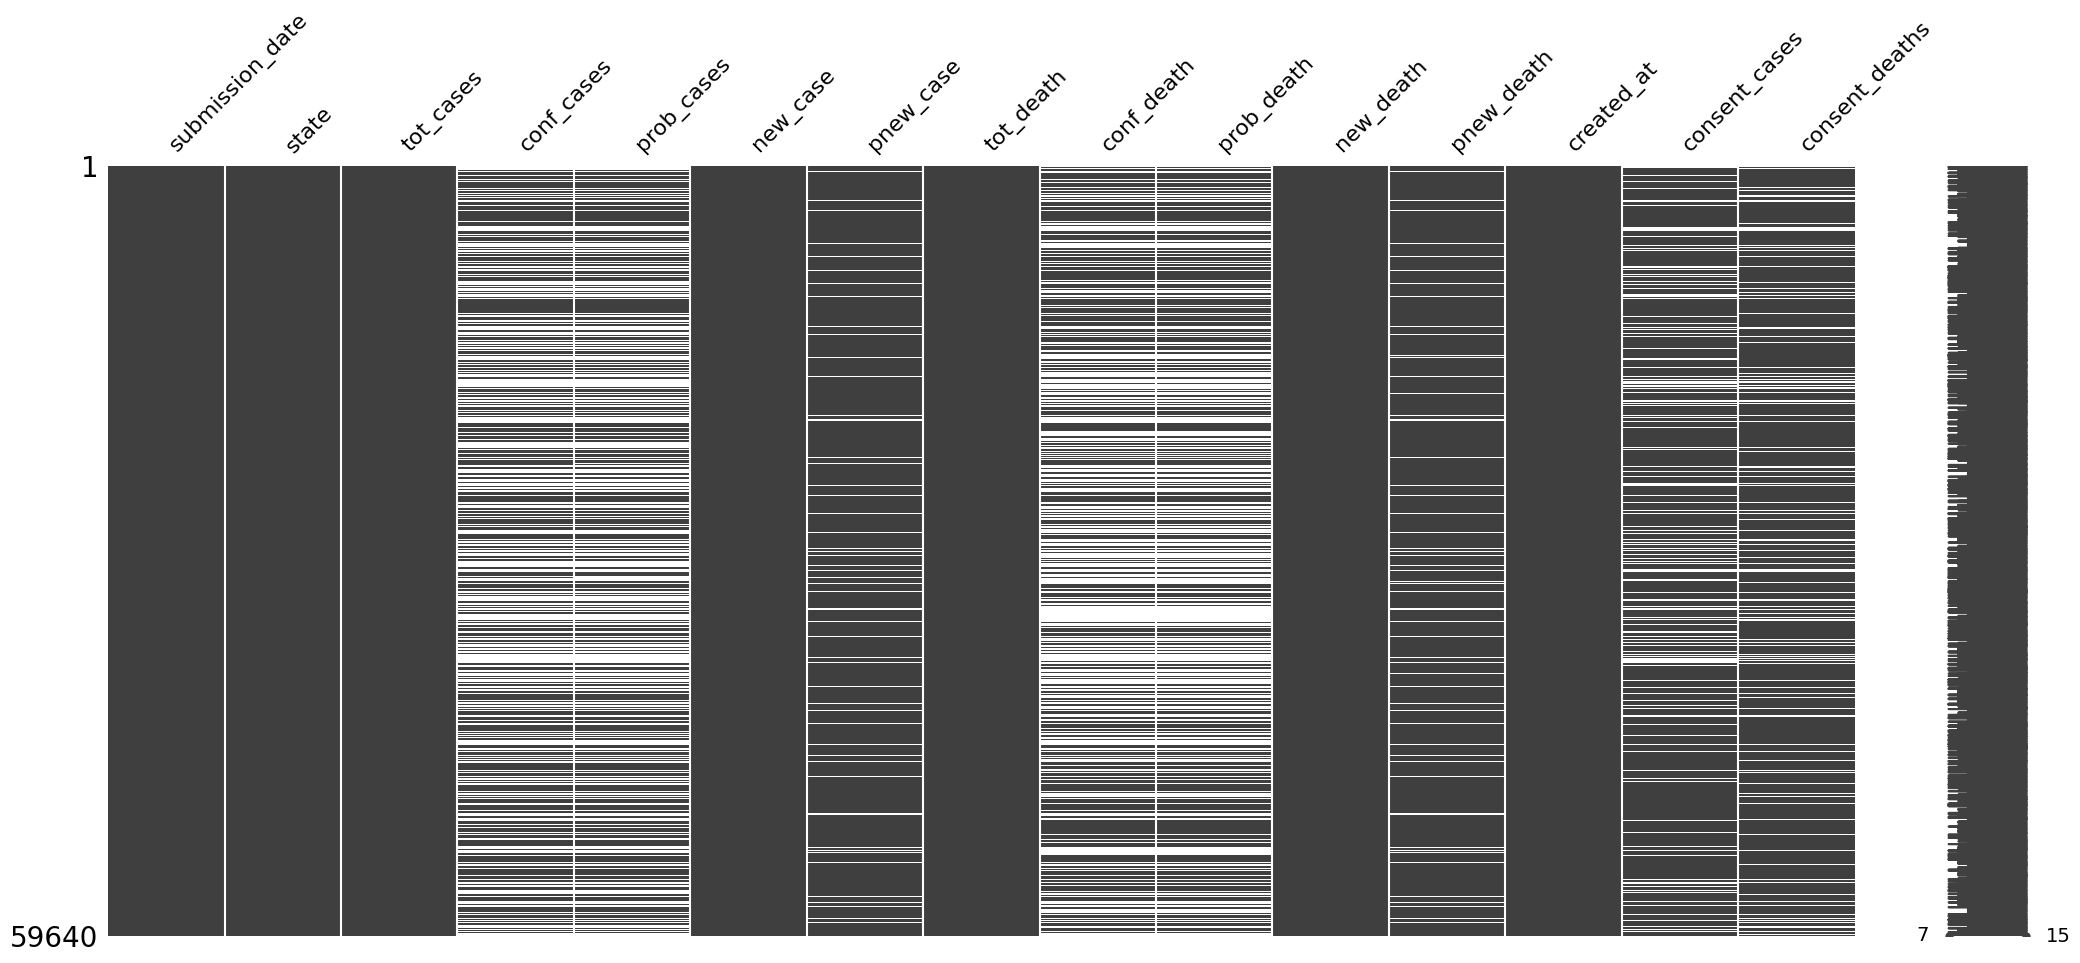

In [2]:
covid = pd.read_csv('../data/United_States_COVID-19_Cases_and_Deaths_by_State_over_Time.csv')
covid['submission_date'] = pd.to_datetime(covid['submission_date'])
msno.matrix(covid);

In [3]:
covid = covid[['submission_date','state','tot_cases','new_case','tot_death','new_death']]
covid = covid.rename(columns={'submission_date': 'Date'})
covid.set_index('Date', inplace=True)
covid.sort_index(inplace=True)
covid

state  tot_cases new_case tot_death new_death
Date                                                    
2020-01-22    AS          0        0         0         0
2020-01-22   NYC          0        0         0         0
2020-01-22    AL          0        0         0         0
2020-01-22    GU          0        0         0         0
2020-01-22    DC          0        0         0         0
...          ...        ...      ...       ...       ...
2022-10-11    HI    348,570        0     1,682         0
2022-10-11    MP     13,171        0        40         0
2022-10-11    UT  1,040,147        0     5,028         0
2022-10-11    AS      8,250        0        34         0
2022-10-11    RI    406,546        0     3,674         0

[59640 rows x 5 columns]

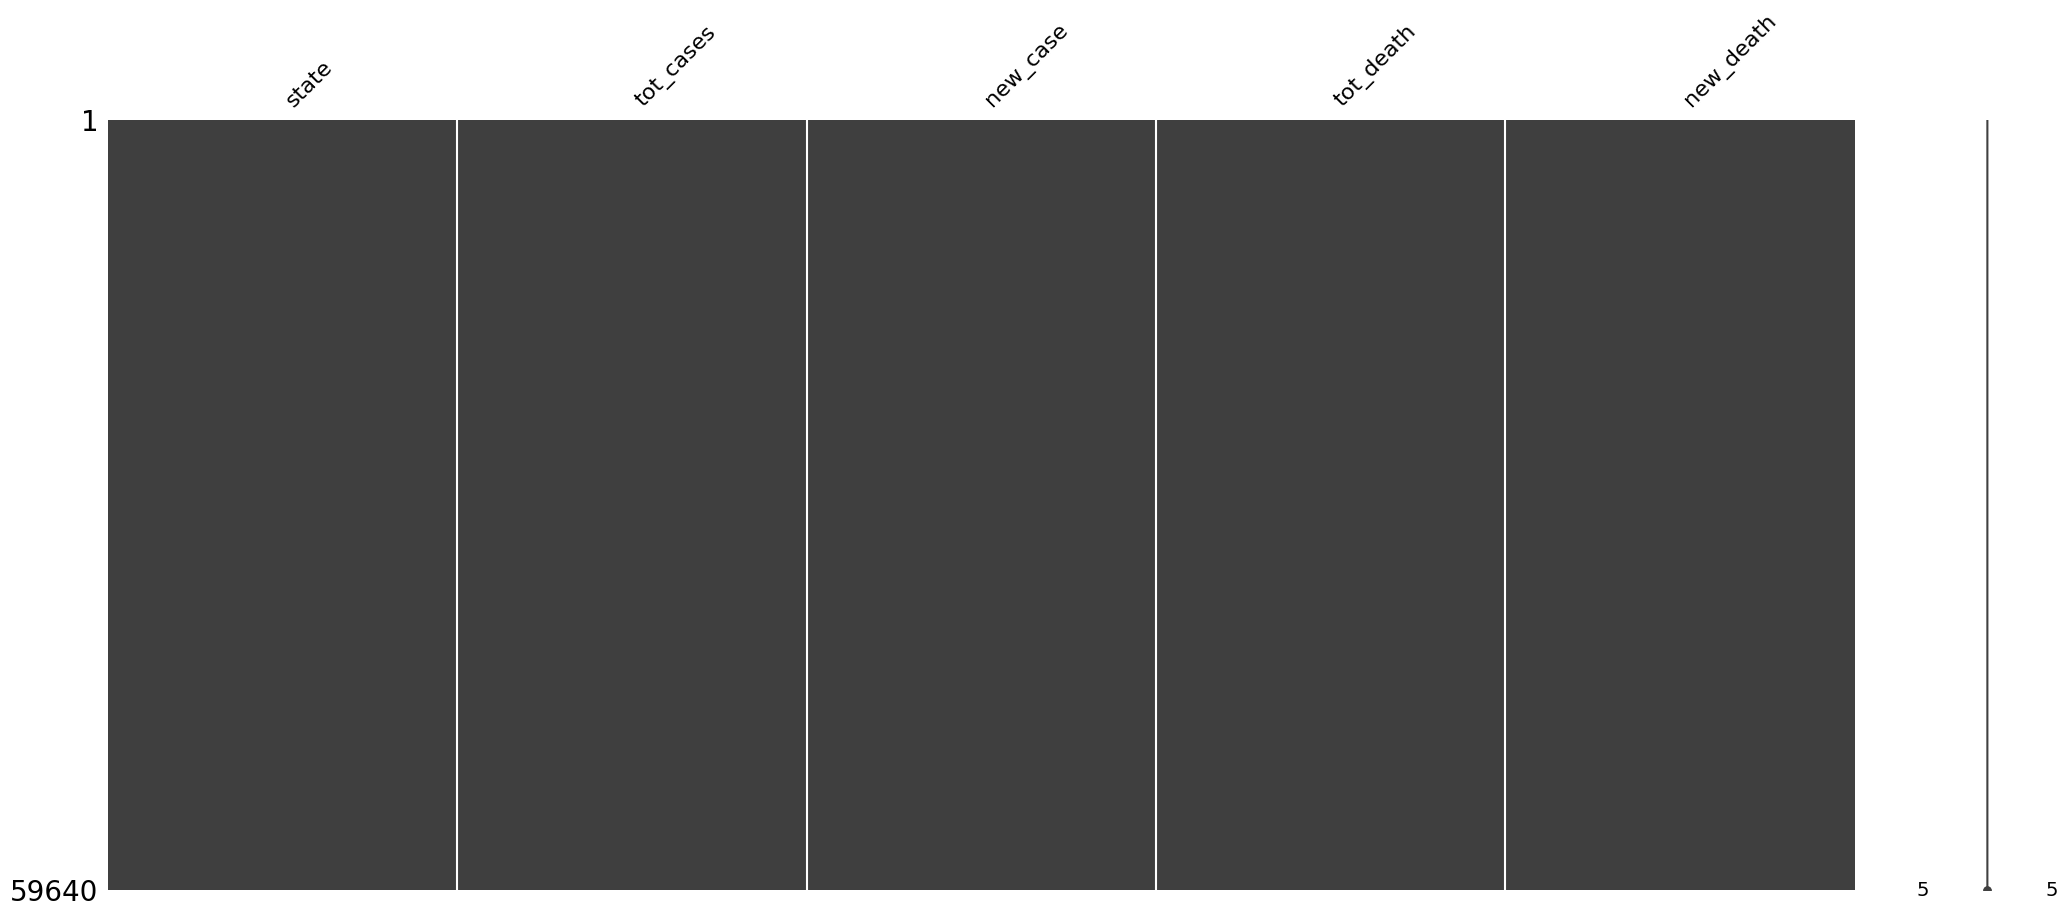

In [4]:
msno.matrix(covid);

In [5]:
col =['tot_cases', 'new_case', 'tot_death', 'new_death']
for c in col:
    covid[c] = covid[c].map( lambda x: x.replace(',','')).astype(int)
covid.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 59640 entries, 2020-01-22 to 2022-10-11
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   state      59640 non-null  object
 1   tot_cases  59640 non-null  int64 
 2   new_case   59640 non-null  int64 
 3   tot_death  59640 non-null  int64 
 4   new_death  59640 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 2.7+ MB


In [6]:
covid.shape

(59640, 5)

In [7]:
covid.to_csv('../data/clean_data/covid_cases_us_clean.csv')

In [8]:
df_cases = covid.copy()
df = covid.copy()

##  Cases in US


I will perform EDA for US cases so I need to sum cases from all states. After this, this I will sum the cases for the same dates using group by index. 
I will use I can't use `'new_case'` and `'new_death'` columns because column `'tot_cases'` is acumulative and I will need to sum the cases.

In [9]:
# Checking Dataset
df

state  tot_cases  new_case  tot_death  new_death
Date                                                       
2020-01-22    AS          0         0          0          0
2020-01-22   NYC          0         0          0          0
2020-01-22    AL          0         0          0          0
2020-01-22    GU          0         0          0          0
2020-01-22    DC          0         0          0          0
...          ...        ...       ...        ...        ...
2022-10-11    HI     348570         0       1682          0
2022-10-11    MP      13171         0         40          0
2022-10-11    UT    1040147         0       5028          0
2022-10-11    AS       8250         0         34          0
2022-10-11    RI     406546         0       3674          0

[59640 rows x 5 columns]

In [10]:
df = df.groupby(by=df.index).sum()
df.head()

tot_cases  new_case  tot_death  new_death
Date                                                 
2020-01-22          4         4          0          0
2020-01-23          6         2          0          0
2020-01-24          7         1          0          0
2020-01-25          7         0          0          0
2020-01-26          8         1          0          0

In [11]:
df.head()

tot_cases  new_case  tot_death  new_death
Date                                                 
2020-01-22          4         4          0          0
2020-01-23          6         2          0          0
2020-01-24          7         1          0          0
2020-01-25          7         0          0          0
2020-01-26          8         1          0          0

In [12]:
df_us_plot = df.resample('W').mean()

fig = px.area(df_us_plot, x=df_us_plot.index, y='new_case', title='Covid Cases in US Overall', labels='counts')
fig.add_trace(go.Bar(x=df.index, y=df['new_case']))
fig.show()


In [13]:
df_us_plot = df.resample('W').mean()

fig = px.area(df_us_plot, x=df_us_plot.index, y='new_death', title='Covid Deaths in US Overall', labels='counts')
fig.add_trace(go.Bar(x=df.index, y=df['new_death']))
fig.show()

In [14]:
df.head()

tot_cases  new_case  tot_death  new_death
Date                                                 
2020-01-22          4         4          0          0
2020-01-23          6         2          0          0
2020-01-24          7         1          0          0
2020-01-25          7         0          0          0
2020-01-26          8         1          0          0

# Times Series EDA
---

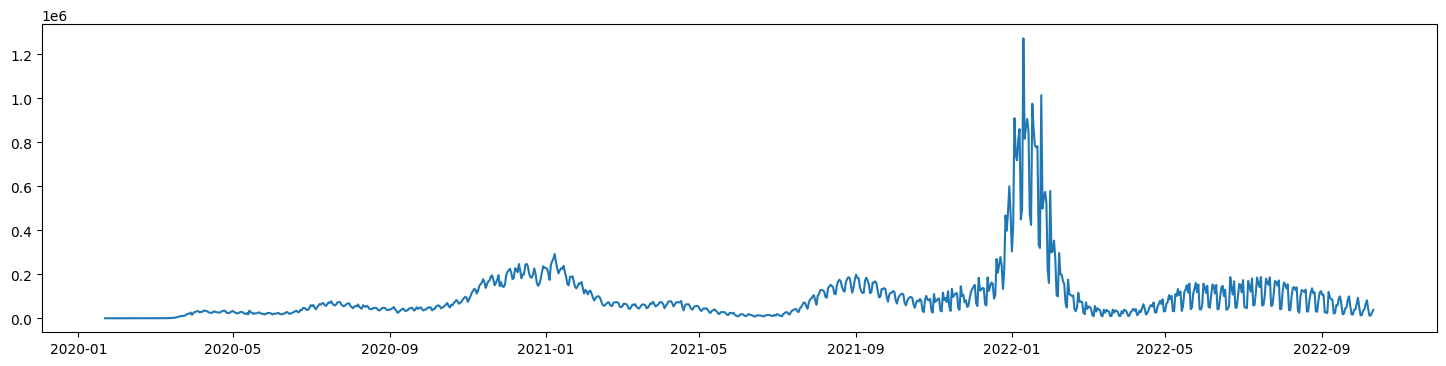

In [15]:
plt.figure(figsize=(18,4))
plt.plot(df['new_case']);

In [16]:
df_case_death = df.resample('W').mean()

In [17]:
df_case_death.head()

tot_cases  new_case  tot_death  new_death
Date                                                 
2020-01-26   6.400000  1.600000        0.0        0.0
2020-02-02   9.142857  0.714286        0.0        0.0
2020-02-09  19.142857  1.000000        0.0        0.0
2020-02-16  22.428571  0.571429        0.0        0.0
2020-02-23  37.428571  3.428571        0.0        0.0

In [18]:
df['moving_average_1'] = df['new_case'].rolling(window=1).mean()
df['moving_average_4'] = df['new_case'].rolling(window=4).mean()
df['moving_average_13'] = df['new_case'].rolling(window=13).mean()
df.dropna(inplace=True)
df.head()

tot_cases  new_case  tot_death  new_death  moving_average_1  \
Date                                                                      
2020-02-03         17         4          0          0               4.0   
2020-02-04         19         2          0          0               2.0   
2020-02-05         19         0          0          0               0.0   
2020-02-06         19         0          0          0               0.0   
2020-02-07         20         1          0          0               1.0   

            moving_average_4  moving_average_13  
Date                                             
2020-02-03              2.25           1.307692  
2020-02-04              2.50           1.153846  
2020-02-05              2.25           1.000000  
2020-02-06              1.50           0.923077  
2020-02-07              0.75           1.000000

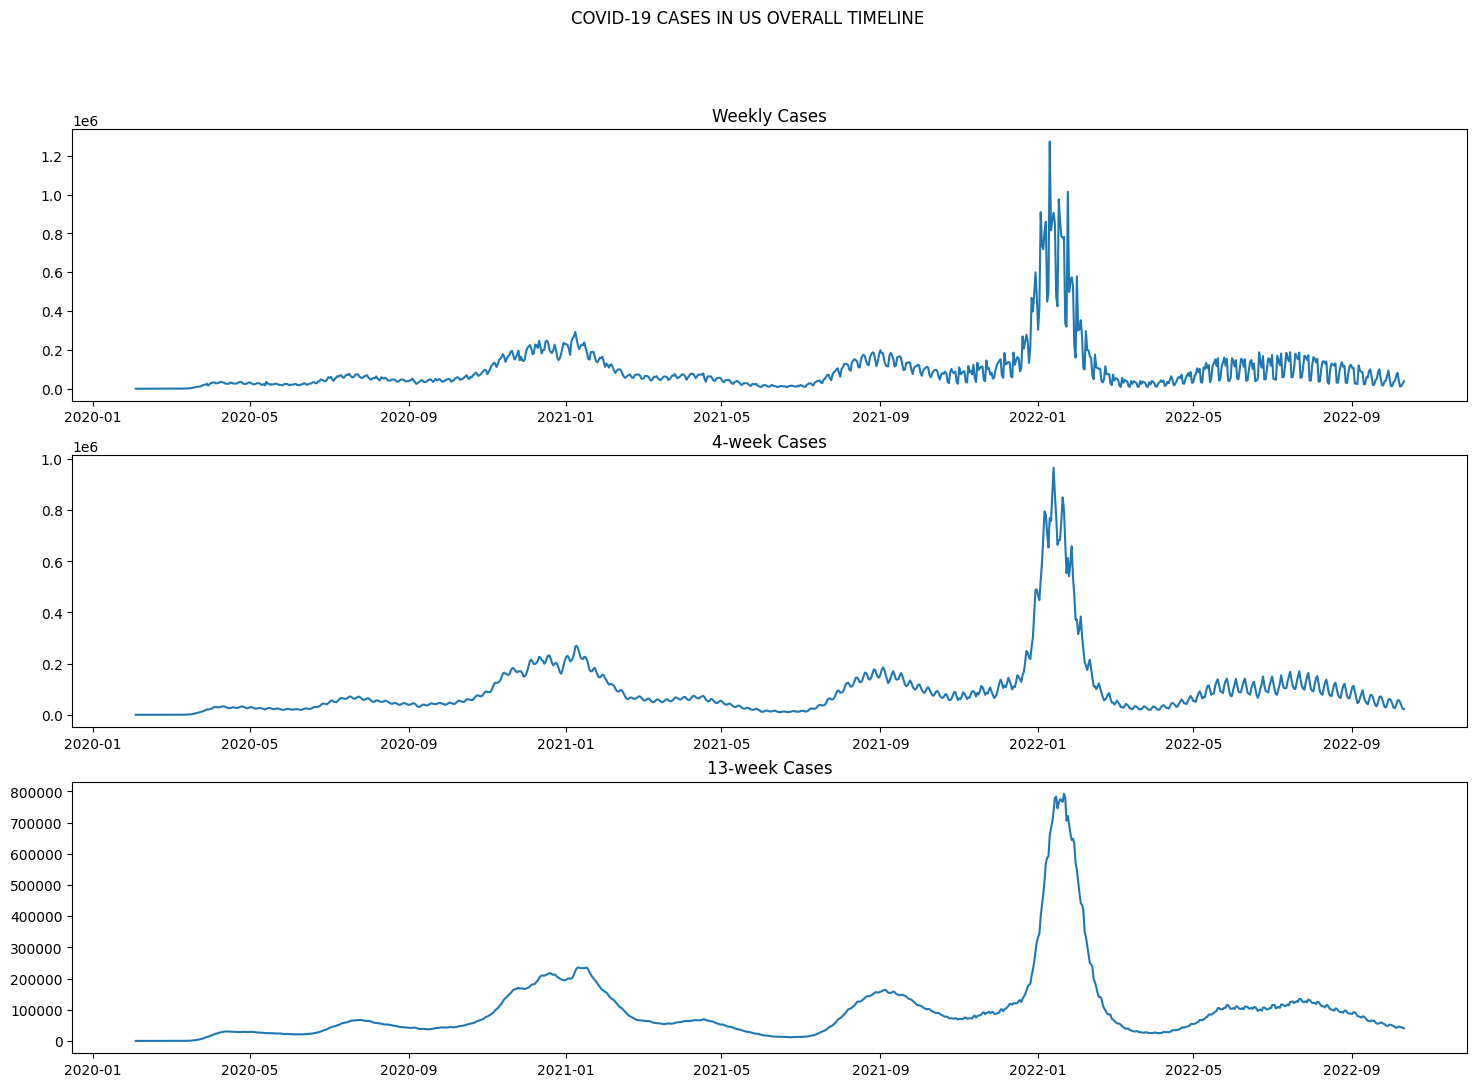

In [19]:
fig, axes = plt.subplots(nrows=3, figsize=(18,12))

axes[0].plot(df['moving_average_1'])
axes[1].plot(df['moving_average_4'])
axes[2].plot(df['moving_average_13'])

fig.suptitle('COVID-19 CASES IN US OVERALL TIMELINE');
axes[0].title.set_text('Weekly Cases')
axes[1].title.set_text('4-week Cases')
axes[2].title.set_text('13-week Cases')


# Cases by State
____

In [21]:
df_cases

state  tot_cases  new_case  tot_death  new_death
Date                                                       
2020-01-22    AS          0         0          0          0
2020-01-22   NYC          0         0          0          0
2020-01-22    AL          0         0          0          0
2020-01-22    GU          0         0          0          0
2020-01-22    DC          0         0          0          0
...          ...        ...       ...        ...        ...
2022-10-11    HI     348570         0       1682          0
2022-10-11    MP      13171         0         40          0
2022-10-11    UT    1040147         0       5028          0
2022-10-11    AS       8250         0         34          0
2022-10-11    RI     406546         0       3674          0

[59640 rows x 5 columns]

In [22]:
df_cases.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 59640 entries, 2020-01-22 to 2022-10-11
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   state      59640 non-null  object
 1   tot_cases  59640 non-null  int64 
 2   new_case   59640 non-null  int64 
 3   tot_death  59640 non-null  int64 
 4   new_death  59640 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 2.7+ MB


In [23]:
df_ = df_cases.loc['2022-06':'2022-10'].groupby(by='state').sum()
df5_state_cases = df_.sort_values(by='tot_cases', ascending=False).head(5)
states5_list = df5_state_cases.index
states5_list

Index(['CA', 'TX', 'FL', 'IL', 'PA'], dtype='object', name='state')

In [24]:
df_cases_states = df_cases.groupby(by='state').sum()
df_cases_states.sort_values(by='new_case', ascending=False)

df_cases_states.to_csv('../streamlit/pages/plotting/plot_cases_deaths_state.csv')
df_cases_states


tot_cases  new_case  tot_death  new_death
state                                            
AK      103800015    282632     533125       1186
AL      638327202   1528319   10915844      20498
AR      403775153    954552    5830937      12041
AS        1382283      8250       5776         34
AZ      978893192   2275235   15992140      31644
CA     4364733842  11107087   50457009      95414
CO      658900625   1660829    6600246      13348
CT      367082955    888009    7159317      11385
DC       64506024    168122     929885       1383
DE      123511033    310527    1674285       3094
FL     2877176184   7135916   40188788      81807
FSM        753724     22005       1997         51
GA     1256065315   2898910   20057017      39908
GU       18298026     58647     171781        399
HI       96019895    335545     655122       1682
IA      390168331    854980    5253659      10125
ID      216319232    497007    2394459       5187
IL     1535904620   3778171   22194980      39791
IN      826545624   1924345   12704876      24748
KS      367118827    880197    4551055       9045
KY      605488868   1597566    8132143      17131
LA      590492442   1365729   10256566      18120
MA      813473206   2059179   14732297      25550
MD      508846790   1257358    8565843      15455
ME      100313491    292654    1008102       2621
MI     1143810923   2860770   19618601      33419
MN      683721274   1661920    6973404      13496
MO      698151846   1645029   10055057      18610
MP        3169106     13171      10826         40
MS      390667852    919938    7138044      11689
MT      130318670    310008    1654489       3472
NC     1233122110   3221966   13187799      26889
ND      119737804    270288    1303518       2383
NE      238090381    517065    2197571       4156
NH      130358243    352606    1308866       2713
NJ     1102833421   2770444   22698466      32968
NM      244753570    621166    3924141       8391
NV      360314431    793069    5511467      11144
NY     1301856010   3259603   17308667      29549
NYC    1118339865   2897546   29278250      42097
OH     1276191903   3149589   19056947      36187
OK      509948964   1201654    7254969      13848
OR      311165942    899013    3390079       8590
PA     1328107988   3249979   24628308      47169
PR      246444841    963373    2319777       5178
PW        1209901      5510       1440          6
RI      163311965    406546    2238442       3674
RMI        827571     15375        934         17
SC      703355936   1715434    9396256      18468
SD      123303578    261537    1647941       3033
TN      985632802   2327351   12689455      25437
TX     3307212352   7691340   47538683      89344
UT      451582481   1040147    2350692       5018
VA      800947192   2099126   10365763      21986
VI        7188849     23103      52258        123
VT       42676851    133252     288765        698
WA      644705150   1825126    6442064      14417
WI      775370683   1875895    7409068      15321
WV      219275324    603256    3159079       7387
WY       74375640    177635     845670       1904

In [25]:
df_fips = pd.read_csv('../data/states_fips.csv')

In [26]:
list_state = list(df_cases.groupby(by='state').sum().index)
list_fips = list(df_fips['postal_code'])

In [27]:
set(list_state) - set(list_fips)

{'FSM', 'NYC', 'PW', 'RMI'}

In [28]:
# These are not US state
# FSM: Federated States of Micronesia
# PW: Palau
# RMI: Republic of Marshall Islands
not_state_list = ['FSM', 'PW', 'RMI', 'AS', 'GU', 'MP', 'PR', 'VI']

#### Let's checking for 5th states with higher covid cases/increasing trends recently (2022-07 until 2022-09).


In [29]:
df_recent = df_cases.loc['2022-07':'2022-09']

In [30]:
df_recent_states = df_recent.groupby(by='state').sum()
df_5state_recent_cases = df_recent_states.sort_values(by='new_case', ascending=False).head(5)
df5_state_cases


tot_cases  new_case  tot_death  new_death
state                                            
CA     1415290154   1681834   12377966       4695
TX      991447676   1031121   11700763       2527
FL      902598100    965939   10471082       6827
IL      475483264    475755    5187490       1656
PA      413327162    341282    6159392       2139

In [31]:
# Creating a list with 5 states with higher number of cases recently
states5_list = df_5state_recent_cases.index
states5_list

Index(['CA', 'TX', 'FL', 'IL', 'NC'], dtype='object', name='state')

In [32]:
df_recent[df_recent['state']==('CA'or'TX'or 'FL'or'NC'or'IL')]

state  tot_cases  new_case  tot_death  new_death
Date                                                       
2022-07-01    CA   10143414     67396      91701        185
2022-07-02    CA   10143414         0      91701          0
2022-07-03    CA   10143414         0      91701          0
2022-07-04    CA   10143414         0      91701          0
2022-07-05    CA   10212491     69077      91795         94
...          ...        ...       ...        ...        ...
2022-09-26    CA   11220161         0      95009          0
2022-09-27    CA   11220161         0      95009          0
2022-09-28    CA   11220161         0      95009          0
2022-09-29    CA   11247840     27679      95165        156
2022-09-30    CA   11253453      5613      95165          0

[92 rows x 5 columns]

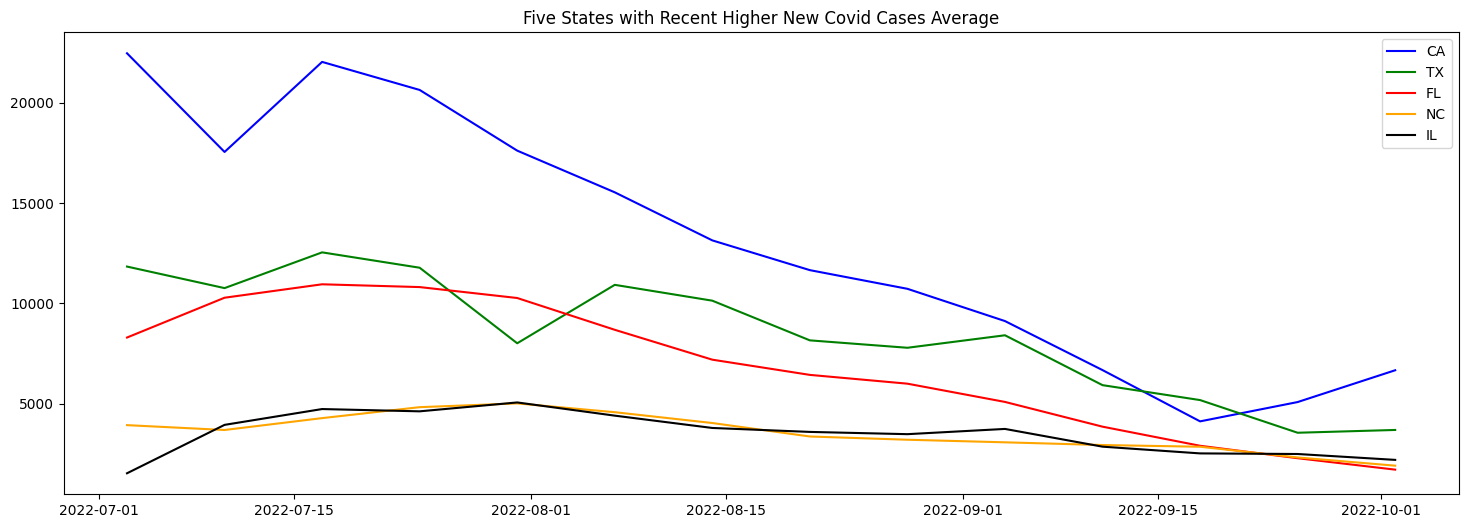

In [33]:
#['CA', 'TX', 'FL', 'IL', 'NC']
plt.figure(figsize=(18,6))
plt.plot(df_recent[df_recent['state']=='CA']['new_case'].resample('W').mean(), color='blue', label='CA')
plt.plot(df_recent[df_recent['state']=='TX']['new_case'].resample('W').mean(), color='green', label='TX')
plt.plot(df_recent[df_recent['state']=='FL']['new_case'].resample('W').mean(), color='red', label='FL')
plt.plot(df_recent[df_recent['state']=='NC']['new_case'].resample('W').mean(), color='orange', label='NC')
plt.plot(df_recent[df_recent['state']=='IL']['new_case'].resample('W').mean(), color='black', label='IL')


plt.title('Five States with Recent Higher New Covid Cases Average')
plt.xlabel('')
plt.ylabel('')
plt.legend();


In [34]:
df_cases_states = df_cases.groupby(by='state').sum()
df_cases_states.shape

(60, 4)

In [35]:
# Deleting theses 'states' ['FSM', 'PW', 'RMI', 'AS', 'GU', 'MP', 'PR', 'VI']
# Keeping DC and NYC. Total of 52 'US states'
df_cases_states.drop(index = not_state_list, inplace=True)
df_cases_states.shape

(52, 4)

In [36]:
df_cases_states.sort_index()

tot_cases  new_case  tot_death  new_death
state                                            
AK      103800015    282632     533125       1186
AL      638327202   1528319   10915844      20498
AR      403775153    954552    5830937      12041
AZ      978893192   2275235   15992140      31644
CA     4364733842  11107087   50457009      95414
CO      658900625   1660829    6600246      13348
CT      367082955    888009    7159317      11385
DC       64506024    168122     929885       1383
DE      123511033    310527    1674285       3094
FL     2877176184   7135916   40188788      81807
GA     1256065315   2898910   20057017      39908
HI       96019895    335545     655122       1682
IA      390168331    854980    5253659      10125
ID      216319232    497007    2394459       5187
IL     1535904620   3778171   22194980      39791
IN      826545624   1924345   12704876      24748
KS      367118827    880197    4551055       9045
KY      605488868   1597566    8132143      17131
LA      590492442   1365729   10256566      18120
MA      813473206   2059179   14732297      25550
MD      508846790   1257358    8565843      15455
ME      100313491    292654    1008102       2621
MI     1143810923   2860770   19618601      33419
MN      683721274   1661920    6973404      13496
MO      698151846   1645029   10055057      18610
MS      390667852    919938    7138044      11689
MT      130318670    310008    1654489       3472
NC     1233122110   3221966   13187799      26889
ND      119737804    270288    1303518       2383
NE      238090381    517065    2197571       4156
NH      130358243    352606    1308866       2713
NJ     1102833421   2770444   22698466      32968
NM      244753570    621166    3924141       8391
NV      360314431    793069    5511467      11144
NY     1301856010   3259603   17308667      29549
NYC    1118339865   2897546   29278250      42097
OH     1276191903   3149589   19056947      36187
OK      509948964   1201654    7254969      13848
OR      311165942    899013    3390079       8590
PA     1328107988   3249979   24628308      47169
RI      163311965    406546    2238442       3674
SC      703355936   1715434    9396256      18468
SD      123303578    261537    1647941       3033
TN      985632802   2327351   12689455      25437
TX     3307212352   7691340   47538683      89344
UT      451582481   1040147    2350692       5018
VA      800947192   2099126   10365763      21986
VT       42676851    133252     288765        698
WA      644705150   1825126    6442064      14417
WI      775370683   1875895    7409068      15321
WV      219275324    603256    3159079       7387
WY       74375640    177635     845670       1904

In [37]:
df_cases_states.head()

tot_cases  new_case  tot_death  new_death
state                                            
AK      103800015    282632     533125       1186
AL      638327202   1528319   10915844      20498
AR      403775153    954552    5830937      12041
AZ      978893192   2275235   15992140      31644
CA     4364733842  11107087   50457009      95414

In [38]:
total_covid_cases = df_cases_states['new_case'].sum()
total_covid_cases

94811167

In [39]:
df_cases_states['pct_cases'] = df_cases_states['new_case']/total_covid_cases*100
df_cases_states.head(50).sort_values(by='pct_cases', ascending=False)

tot_cases  new_case  tot_death  new_death  pct_cases
state                                                       
CA     4364733842  11107087   50457009      95414  11.714957
TX     3307212352   7691340   47538683      89344   8.112272
FL     2877176184   7135916   40188788      81807   7.526451
IL     1535904620   3778171   22194980      39791   3.984943
NY     1301856010   3259603   17308667      29549   3.437995
PA     1328107988   3249979   24628308      47169   3.427844
NC     1233122110   3221966   13187799      26889   3.398298
OH     1276191903   3149589   19056947      36187   3.321960
GA     1256065315   2898910   20057017      39908   3.057562
NYC    1118339865   2897546   29278250      42097   3.056123
MI     1143810923   2860770   19618601      33419   3.017334
NJ     1102833421   2770444   22698466      32968   2.922065
TN      985632802   2327351   12689455      25437   2.454722
AZ      978893192   2275235   15992140      31644   2.399754
VA      800947192   2099126   10365763      21986   2.214007
MA      813473206   2059179   14732297      25550   2.171874
IN      826545624   1924345   12704876      24748   2.029661
WI      775370683   1875895    7409068      15321   1.978559
WA      644705150   1825126    6442064      14417   1.925012
SC      703355936   1715434    9396256      18468   1.809316
MN      683721274   1661920    6973404      13496   1.752874
CO      658900625   1660829    6600246      13348   1.751723
MO      698151846   1645029   10055057      18610   1.735058
KY      605488868   1597566    8132143      17131   1.684998
AL      638327202   1528319   10915844      20498   1.611961
LA      590492442   1365729   10256566      18120   1.440473
MD      508846790   1257358    8565843      15455   1.326171
OK      509948964   1201654    7254969      13848   1.267418
UT      451582481   1040147    2350692       5018   1.097072
AR      403775153    954552    5830937      12041   1.006793
MS      390667852    919938    7138044      11689   0.970284
OR      311165942    899013    3390079       8590   0.948214
CT      367082955    888009    7159317      11385   0.936608
KS      367118827    880197    4551055       9045   0.928368
IA      390168331    854980    5253659      10125   0.901771
NV      360314431    793069    5511467      11144   0.836472
NM      244753570    621166    3924141       8391   0.655161
NE      238090381    517065    2197571       4156   0.545363
ID      216319232    497007    2394459       5187   0.524207
RI      163311965    406546    2238442       3674   0.428795
NH      130358243    352606    1308866       2713   0.371903
HI       96019895    335545     655122       1682   0.353909
DE      123511033    310527    1674285       3094   0.327522
MT      130318670    310008    1654489       3472   0.326974
ME      100313491    292654    1008102       2621   0.308670
AK      103800015    282632     533125       1186   0.298100
ND      119737804    270288    1303518       2383   0.285080
SD      123303578    261537    1647941       3033   0.275850
DC       64506024    168122     929885       1383   0.177323
VT       42676851    133252     288765        698   0.140545

In [40]:
df.head()

tot_cases  new_case  tot_death  new_death  moving_average_1  \
Date                                                                      
2020-02-03         17         4          0          0               4.0   
2020-02-04         19         2          0          0               2.0   
2020-02-05         19         0          0          0               0.0   
2020-02-06         19         0          0          0               0.0   
2020-02-07         20         1          0          0               1.0   

            moving_average_4  moving_average_13  
Date                                             
2020-02-03              2.25           1.307692  
2020-02-04              2.50           1.153846  
2020-02-05              2.25           1.000000  
2020-02-06              1.50           0.923077  
2020-02-07              0.75           1.000000

In [41]:
df_cases_states.head(2)

tot_cases  new_case  tot_death  new_death  pct_cases
state                                                      
AK     103800015    282632     533125       1186   0.298100
AL     638327202   1528319   10915844      20498   1.611961

In [42]:
df_cases_0 = df_cases.copy()

In [43]:

df_cases_0['date_plot'] = df_cases_0.index.map(lambda x: x.strftime('%Y-%m-%d'))
df_cases_0

state  tot_cases  new_case  tot_death  new_death   date_plot
Date                                                                   
2020-01-22    AS          0         0          0          0  2020-01-22
2020-01-22   NYC          0         0          0          0  2020-01-22
2020-01-22    AL          0         0          0          0  2020-01-22
2020-01-22    GU          0         0          0          0  2020-01-22
2020-01-22    DC          0         0          0          0  2020-01-22
...          ...        ...       ...        ...        ...         ...
2022-10-11    HI     348570         0       1682          0  2022-10-11
2022-10-11    MP      13171         0         40          0  2022-10-11
2022-10-11    UT    1040147         0       5028          0  2022-10-11
2022-10-11    AS       8250         0         34          0  2022-10-11
2022-10-11    RI     406546         0       3674          0  2022-10-11

[59640 rows x 6 columns]

In [44]:
import plotly.express as px
import pandas as pd


px.choropleth(df_cases_0, 
              locations = 'state',
              color="new_case", 
              animation_frame='date_plot',
              color_continuous_scale="sunset",
              locationmode='USA-states',
              scope="usa",
              range_color=(0, 10009),
              title='Timeline Covid Cases In US by State',
              height=600
             )

In [45]:
df_cases_states.head()

tot_cases  new_case  tot_death  new_death  pct_cases
state                                                       
AK      103800015    282632     533125       1186   0.298100
AL      638327202   1528319   10915844      20498   1.611961
AR      403775153    954552    5830937      12041   1.006793
AZ      978893192   2275235   15992140      31644   2.399754
CA     4364733842  11107087   50457009      95414  11.714957

In [46]:
px.choropleth(df_cases_0, 
              locations = 'state',
              color="new_death", 
              animation_frame='date_plot',
              color_continuous_scale="mint",
              locationmode='USA-states',
              scope="usa",
              range_color=(0, 180),
              title='Timeline Covid Deaths In US by State',
              height=600
             )

# Vacination Data
____


In [47]:
df_vacc = pd.read_csv('../data/clean_data/covid_vaccination_trends_clean.csv', low_memory=False)
df_vacc['Date'] = pd.to_datetime(df_vacc['Date'])
df_vacc.set_index('Date', inplace=True)
df_vacc.sort_index(inplace=True)
df_vacc.head(3)

Location  Administered_Daily  Administered_Cumulative  \
Date                                                               
2020-12-13       GU                 0.0                      0.0   
2020-12-13       FM                 0.0                      0.0   
2020-12-13       MA                 2.0                      2.0   

            Administered_7_Day_Rolling_Average  Admin_Dose_1_Daily  \
Date                                                                 
2020-12-13                                 0.0                 0.0   
2020-12-13                                 0.0                 0.0   
2020-12-13                                 2.0                22.0   

            Admin_Dose_1_Cumulative  Admin_Dose_1_Day_Rolling_Average  \
Date                                                                    
2020-12-13                      0.0                               0.0   
2020-12-13                      0.0                               0.0   
2020-12-13                     22.0                              22.0   

            Administered_Dose1_Pop_Pct  Administered_daily_change_report  \
Date                                                                       
2020-12-13                         0.0                               0.0   
2020-12-13                         0.0                               0.0   
2020-12-13                         0.0                               2.0   

            Administered_daily_change_report_7dayroll  ...  \
Date                                                   ...   
2020-12-13                                        0.0  ...   
2020-12-13                                        0.0  ...   
2020-12-13                                        2.0  ...   

            Series_Complete_Day_Rolling_Average  Series_Complete_Pop_Pct  \
Date                                                                       
2020-12-13                                  0.0                      0.0   
2020-12-13                                  0.0                      0.0   
2020-12-13                                  4.0                      0.0   

            Booster_Daily  Booster_Cumulative  Booster_7_Day_Rolling_Average  \
Date                                                                           
2020-12-13            0.0                 0.0                            0.0   
2020-12-13            0.0                 0.0                            0.0   
2020-12-13            0.0                 0.0                            0.0   

            Additional_Doses_Vax_Pct  Second_Booster_50Plus_Daily  \
Date                                                                
2020-12-13                       0.0                          0.0   
2020-12-13                       0.0                          0.0   
2020-12-13                       0.0                          0.0   

            Second_Booster_50Plus_Cumulative  \
Date                                           
2020-12-13                               0.0   
2020-12-13                               0.0   
2020-12-13                               0.0   

            Second_Booster_50Plus_7_Day_Rolling_Average  \
Date                                                      
2020-12-13                                          0.0   
2020-12-13                                          0.0   
2020-12-13                                          0.0   

            Second_Booster_50Plus_Vax_Pct  
Date                                       
2020-12-13                            0.0  
2020-12-13                            0.0  
2020-12-13                            0.0  

[3 rows x 22 columns]

# Travel Data 
----

In [48]:
df_travel = pd.read_csv('../data/clean_data/travel_data_clean.csv')
df_travel['Date'] = pd.to_datetime(df_travel['Date'])
df_travel.set_index('Date', inplace=True)
df_travel.sort_index(inplace=True)
df_travel.head(3)

Unnamed: 0   Level  State FIPS State Postal Code  County FIPS  \
Date                                                                        
2019-01-01       48496  County        19.0                IA      19099.0   
2019-01-01       48244  County        22.0                LA      22041.0   
2019-01-01       48245  County        22.0                LA      22043.0   

                County Name  Population Staying at Home  \
Date                                                      
2019-01-01    Jasper County                      9808.0   
2019-01-01  Franklin Parish                      3370.0   
2019-01-01     Grant Parish                      3812.0   

            Population Not Staying at Home  Number of Trips  \
Date                                                          
2019-01-01                         27377.0         105067.0   
2019-01-01                         16645.0          58353.0   
2019-01-01                         18577.0          63157.0   

            Number of Trips <1  ...  Number of Trips 5-10  \
Date                            ...                         
2019-01-01             25699.0  ...               12076.0   
2019-01-01             13234.0  ...               10190.0   
2019-01-01             12498.0  ...                9178.0   

            Number of Trips 10-25  Number of Trips 25-50  \
Date                                                       
2019-01-01                14098.0                12562.0   
2019-01-01                 8404.0                 3921.0   
2019-01-01                10369.0                 4178.0   

            Number of Trips 50-100  Number of Trips 100-250  \
Date                                                          
2019-01-01                  3154.0                    875.0   
2019-01-01                  1457.0                    499.0   
2019-01-01                  1487.0                   1434.0   

            Number of Trips 250-500  Number of Trips >=500             Row ID  \
Date                                                                            
2019-01-01                    366.0                  121.0  19-19099-20190101   
2019-01-01                     96.0                   93.0  22-22041-20190101   
2019-01-01                    303.0                   85.0  22-22043-20190101   

            Week Month  
Date                    
2019-01-01     0     1  
2019-01-01     0     1  
2019-01-01     0     1  

[3 rows x 22 columns]

# North Carolina Analysis (Vacination/Cases/Travel)
---

North Carolina has the lower vaccination rate in US and a higher number of Covid cases recently so we decide to take a look closer on its data.

In [ ]:
df_nc_vcc = df_vacc[df_vacc["Location"]=='NC']
df_nc_vcc.drop(columns=['Location', 'Administered_Daily', 'Administered_Cumulative','Administered_7_Day_Rolling_Average',
       'Admin_Dose_1_Cumulative', 'Admin_Dose_1_Day_Rolling_Average', 'Administered_daily_change_report',
       'Administered_daily_change_report_7dayroll','Series_Complete_Cumulative', 'Series_Complete_Day_Rolling_Average',
        'Booster_Cumulative','Booster_7_Day_Rolling_Average',
       'Second_Booster_50Plus_Daily','Second_Booster_50Plus_Cumulative','Second_Booster_50Plus_7_Day_Rolling_Average','Second_Booster_50Plus_Vax_Pct'], inplace=True)
df_nc_vcc = df_nc_vcc.groupby(by=df_nc_vcc.index).sum()
df_nc_vcc.head(3)

In [ ]:
df_nc_cases = df_cases[df_cases['state']=='NC']
df_nc_cases.drop(columns=['tot_cases','tot_death'], inplace=True)
df_nc_cases = df_nc_cases.groupby(by=df_nc_cases.index).sum()
df_nc_cases.head(3)

In [ ]:
df_nc_travel = df_travel[df_travel['State Postal Code']=='NC']
df_nc_travel.drop(columns=['Unnamed: 0', 'Level', 'State FIPS',
       'County FIPS', 'County Name',
       'Number of Trips <1', 'Number of Trips 1-3', 'Number of Trips 3-5',
       'Number of Trips 5-10', 'Number of Trips 10-25',
       'Number of Trips 25-50', 'Number of Trips 50-100',
       'Number of Trips 100-250', 'Number of Trips 250-500',
       'Row ID', 'Week', 'Month'], inplace=True)
df_nc_travel = df_nc_travel.groupby(by=df_nc_travel.index).sum()
df_nc_travel.shape

In [ ]:
df_nc_vcc_cases = pd.merge(df_nc_cases, df_nc_vcc, left_index=True, right_index=True, how = 'left')
df_nc_vcc_cases_travel = pd.merge(df_nc_vcc_cases, df_nc_travel, left_index=True, right_index=True, how = 'left')
df_nc_vcc_cases_travel.head(3)

In [ ]:
df_nc_vcc_cases_travel.to_csv('../data/data_nc_VAR_Model.csv')

In [ ]:
df_plot = df_nc_vcc_cases_travel.resample('W').mean()

In [ ]:
df_plot.info()

In [ ]:
df_plot.sort_values(by='Series_Complete_Pop_Pct')

In [ ]:
fig, axes = plt.subplots(nrows=2, figsize=(16,8))

axes[0].plot(df_plot.loc['2021-01-01':'2022-07-01','Admin_Dose_1_Daily'], color = 'green');
axes[0].plot(df_plot.loc['2021-01-01':'2022-07-01','Series_Complete_Daily'], color = 'lightgreen');
axes[0].plot(df_plot.loc['2021-01-01':'2022-07-01','Booster_Daily'], color = 'black');
axes[1].plot(df_plot.loc['2021-01-01':'2022-07-01','new_death'], color = 'red');

fig.suptitle('North Carolina Vaccination and Covid Deaths Over Time')

axes[0].title.set_text('Vaccination')
axes[1].title.set_text('COVID Deaths')

axes[0].legend(['Dose_1_Daily','Series_Complete_Daily','Booster_Daily'])
axes[1].legend(['Deaths']);


In [ ]:
fig, axes = plt.subplots(nrows=2, figsize=(16,8))

axes[0].plot(df_plot.loc['2021-01-01':'2022-07-01','Admin_Dose_1_Daily'], color = 'green');
axes[0].plot(df_plot.loc['2021-01-01':'2022-07-01','Series_Complete_Daily'], color = 'lightgreen');
axes[0].plot(df_plot.loc['2021-01-01':'2022-07-01','Booster_Daily'], color = 'black');
axes[1].plot(df_plot.loc['2021-01-01':'2022-07-01','new_case'],color = 'blue');


fig.suptitle('North Carolina Vaccinations and Covid Cases Over Time')

axes[0].title.set_text('Vaccination')
axes[1].title.set_text('Covid Cases')

axes[0].legend(['Dose_1_Daily','Series_Complete_Daily','Booster_Daily'])
axes[1].legend(['Cases']);


In [ ]:
fig, axes = plt.subplots(nrows=2, figsize=(16,8))

axes[0].plot(df_plot.loc['2021-01-01':'2022-01-01','Admin_Dose_1_Daily'], color = 'green');
axes[0].plot(df_plot.loc['2021-01-01':'2022-01-01','Series_Complete_Daily'], color = 'lightgreen');
axes[0].plot(df_plot.loc['2021-01-01':'2022-01-01','Booster_Daily'], color = 'black');
axes[1].plot(df_plot.loc['2021-01-01':'2022-01-01','Number of Trips >=500'],color = 'orange');


fig.suptitle('North Carolina Vaccinations and Population Not Staying at Home for Trips >=500 Miles')

axes[0].title.set_text('Vaccination')
axes[1].title.set_text('Trips >=500 Miles')

axes[0].legend(['Dose_1_Daily','Series_Complete_Daily','Booster_Daily'])
axes[1].legend(['Trips >=500 Miles']);

# Travel Data (US)
----

In [ ]:
df_travel.drop(columns=['Unnamed: 0', 'Level', 'State FIPS',
       'County FIPS', 'County Name',
       'Number of Trips <1', 'Number of Trips 1-3', 'Number of Trips 3-5',
       'Number of Trips 5-10', 'Number of Trips 10-25',
       'Number of Trips 25-50', 'Number of Trips 50-100',
       'Number of Trips 100-250', 'Number of Trips 250-500',
       'Row ID'], inplace=True)

In [ ]:
df_travel.head(3)

In [ ]:
travel_us = df_travel.groupby(by=df_travel.index).sum()
travel_us

In [ ]:
travel_us = travel_us.resample('W').mean()
travel_us.info()

In [ ]:
travel_us.head(3)

In [ ]:
df_travel_us = travel_us.loc['2020-04':'2022-02']
plt.figure(figsize=(18,4))
#plt.plot(df_travel['Population Staying at Home'].rolling(window=1).mean());
plt.plot(df_travel_us['Number of Trips >=500'].rolling(window=1).mean());
#plt.plot(df['moving_average_1'])
plt.title('Population Not Staying Home US');

In [ ]:
df_cases.info()

In [ ]:
df_cases = df_cases.groupby(by=df_cases.index).sum()
df_cases = df_cases.resample('W').mean()
df_cases

In [ ]:
df_cases = df_cases.loc['2020-04':'2022-10']
plt.figure(figsize=(18,4))
#plt.plot(df_travel['Population Staying at Home'].rolling(window=1).mean());
plt.plot(df_cases['new_case'].rolling(window=1).mean());

#plt.plot(df['moving_average_1'])
plt.title('New cases')

In [ ]:
plt.figure(figsize=(18,4))
plt.plot(df_travel_us['Number of Trips >=500'].rolling(window=1).mean(), color = 'Green');
plt.title('Population Not Staying at Home US');